In [1]:
from config import config
import pandas as pd
import re
import string
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from transformers import AutoModel,AutoTokenizer
import torch
import torch.nn.functional as F
from sklearn.linear_model import Ridge
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb
from tqdm import tqdm
import numpy as np
import warnings
import os
warnings.filterwarnings("ignore")

**Load data**

In [ ]:
train_df = pd.read_csv(config.train)
train_df["src"] = "train"
test_df = pd.read_csv(config.test)
test_df["src"] = "test"
df = pd.concat([train_df,test_df],ignore_index=True)
ss = pd.read_csv(config.submit)
target_cols = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions',]
print(df.shape)
train_df.loc[:,"seq_len"] = train_df.full_text.apply(lambda x: len(x.split(" ")[:config.max_len]))

(3914, 9)


In [ ]:
train_df.seq_len.describe()

count    3911.000000
mean      418.085912
std       148.298828
min        11.000000
25%       298.000000
50%       410.000000
75%       543.000000
max       640.000000
Name: seq_len, dtype: float64

In [ ]:
np.unique(["sdf","sdff","sdf"])

array(['sdf', 'sdff'], dtype='<U4')

In [ ]:
def get_uni(x):
    x = x.split(" ")
    return len(np.unique(x))
train_df.loc[:,"unique_word"] = train_df.full_text.apply(get_uni)

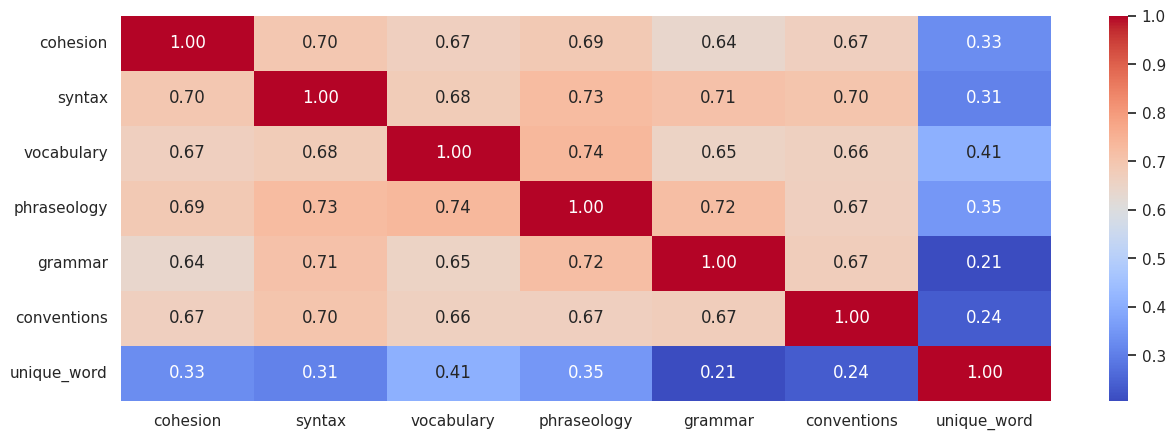

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt
LABEL_COLUMNS = target_cols + ["unique_word"]
corr = train_df[LABEL_COLUMNS].corr()
sns.set(rc = {"figure.figsize": (15, 5)})

sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, annot = True, cmap = "coolwarm", fmt = ".2f")
plt.show()

In [ ]:
from torch.optim.swa_utils import AveragedModel, SWALR

<AxesSubplot:>

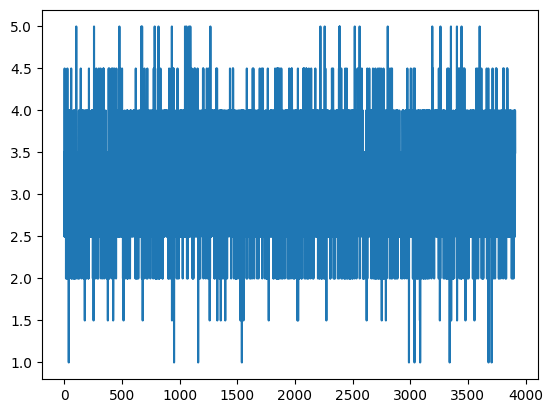

In [ ]:
train_df.cohesion.plot()

**MultilabelStratifiedKFold**

In [ ]:
skf = MultilabelStratifiedKFold(n_splits=config.nfolds, shuffle=True, random_state=config.seed)
for i,(train_index,val_index) in enumerate(skf.split(train_df,train_df[target_cols])):
    train_df.loc[val_index,"fold"] = i
print('Train samples per fold:')
train_df.fold.value_counts()

Train samples per fold:


4.0    783
1.0    782
0.0    782
2.0    782
3.0    782
Name: fold, dtype: int64

In [ ]:
class EmbedDataset(torch.utils.data.Dataset):
    def __init__(self,df,tokenizer,max_len):
        self.df = df.reset_index(drop=True)
        self.max_len = max_len
        self.tokenizer = tokenizer
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        text = self.df.loc[idx,"full_text"]
        tokens = self.tokenizer(
                text,
                None,
                add_special_tokens=True,
                padding='max_length',
                truncation=True,
                max_length=self.max_len,return_tensors="pt")
        tokens = {k:v.squeeze(0) for k,v in tokens.items()}
        return tokens

**Model**

In [ ]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state.detach().cpu()
    input_mask_expanded = (
        attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    )
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(
        input_mask_expanded.sum(1), min=1e-9)

In [ ]:

def get_embeddings(MODEL_NM='', max_len=640,  verbose=True):

    model = AutoModel.from_pretrained( MODEL_NM )
    tokenizer = AutoTokenizer.from_pretrained( MODEL_NM )

    ds_tr = EmbedDataset(train_df,tokenizer,max_len)
    embed_dataloader_tr = torch.utils.data.DataLoader(ds_tr, batch_size=config.bs,shuffle=False)
    ds_te = EmbedDataset(test_df,tokenizer,max_len)
    embed_dataloader_te = torch.utils.data.DataLoader(ds_te, batch_size=config.bs,shuffle=False)

    
    model = model.to(config.device)
    model.eval()
    all_train_text_feats = []
    for batch in tqdm(embed_dataloader_tr,total=len(embed_dataloader_tr)):
        input_ids = batch["input_ids"].to(config.device)
        attention_mask = batch["attention_mask"].to(config.device)
        token_type_ids = batch["token_type_ids"].to(config.device)
        with torch.no_grad():
            model_output = model(input_ids=input_ids,attention_mask=attention_mask,token_type_ids=token_type_ids)
        sentence_embeddings = mean_pooling(model_output, attention_mask.detach().cpu())
        # Normalize the embeddings
        sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
        sentence_embeddings =  sentence_embeddings.detach().cpu().numpy()
        all_train_text_feats.extend(sentence_embeddings)
    all_train_text_feats = np.array(all_train_text_feats)
    if verbose:
        print('Train embeddings shape',all_train_text_feats.shape)
        
    te_text_feats = []
    for batch in tqdm(embed_dataloader_te,total=len(embed_dataloader_te)):
        input_ids = batch["input_ids"].to(config.device)
        attention_mask = batch["attention_mask"].to(config.device)
        token_type_ids = batch["token_type_ids"].to(config.device)
        with torch.no_grad():
            model_output = model(input_ids=input_ids,attention_mask=attention_mask,token_type_ids=token_type_ids)
        sentence_embeddings = mean_pooling(model_output, attention_mask.detach().cpu())
        # Normalize the embeddings
        sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
        sentence_embeddings =  sentence_embeddings.detach().cpu().numpy()
        te_text_feats.extend(sentence_embeddings)
    te_text_feats = np.array(te_text_feats)
    if verbose:
        print('Test embeddings shape',te_text_feats.shape)
        
    return all_train_text_feats, te_text_feats

In [ ]:
all_train_feats = []
all_test_feats = []

In [ ]:
MODEL_NM = "microsoft/deberta-v3-base"
train_text_feats, test_text_feats = get_embeddings(MODEL_NM)
all_train_feats.append(train_text_feats)
all_test_feats.append(test_text_feats)

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaModel: ['lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 978/978 [01:40<00:00,  9.74it/s]


Train embeddings shape (3911, 768)


100%|██████████| 1/1 [00:00<00:00, 11.69it/s]

Test embeddings shape (3, 768)


In [ ]:
MODEL_NM = "microsoft/deberta-base"
model = AutoModel.from_pretrained( MODEL_NM ,attention_probs_dropout_prob=0.,hidden_dropout_prob=0.)

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaModel: ['lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model.config

DebertaConfig {
  "_name_or_path": "microsoft/deberta-base",
  "attention_probs_dropout_prob": 0.0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "c2p",
    "p2c"
  ],
  "position_biased_input": false,
  "relative_attention": true,
  "transformers_version": "4.22.1",
  "type_vocab_size": 0,
  "vocab_size": 50265
}

In [ ]:
all_train_feats = np.concatenate(all_train_feats,axis=1)

all_test_feats = np.concatenate(all_test_feats,axis=1)

In [ ]:
print('Our concatenated embeddings have shape', all_train_feats.shape )

Our concatenated embeddings have shape (3911, 768)


In [ ]:
from sklearn.metrics import mean_squared_error
preds = []
scores = []
def comp_score(y_true,y_pred):
    rmse_scores = []
    for i in range(len(target_cols)):
        rmse_scores.append(np.sqrt(mean_squared_error(y_true[:,i],y_pred[:,i])))
    return np.mean(rmse_scores)

for fold in range(config.nfolds):
    print('#'*25)
    print('### Fold',fold+1)
    print('#'*25)
    train_ = train_df[train_df.fold!=fold]
    val_ = train_df[train_df.fold==fold]
    tr_text_feats = all_train_feats[list(train_.index),:]
    val_text_feats = all_train_feats[list(val_.index),:]
    # val_preds = np.zeros((len(val_text_feats),6))
    test_preds = np.zeros((len(test_text_feats),6))

    model = MultiOutputRegressor(lgb.LGBMRegressor())
    model.fit(tr_text_feats,train_[target_cols])
    val_preds = model.predict(val_text_feats)
    test_preds = model.predict(all_test_feats)
    score = comp_score(val_[target_cols].values,val_preds)
    scores.append(score)
    print("Fold : {} RSME score: {}".format(fold,score))
    preds.append(test_preds)
print('Overall CV RSME =',np.mean(scores))

#########################
### Fold 1
#########################
Fold : 0 RSME score: 0.5025771602799836
#########################
### Fold 2
#########################
Fold : 1 RSME score: 0.48903294198855374
#########################
### Fold 3
#########################
Fold : 2 RSME score: 0.4881211939335335
#########################
### Fold 4
#########################
Fold : 3 RSME score: 0.4858251383521894
#########################
### Fold 5
#########################
Fold : 4 RSME score: 0.5033555610170576
Overall CV RSME = 0.4937823991142635


In [ ]:
sub = test_df.copy()
sub.loc[:,target_cols] = np.average(np.array(preds),axis=0)
sub_columns = pd.read_csv(config.submit).columns
sub = sub[sub_columns]

In [ ]:
sub.to_csv("submission.csv",index=None)
sub.head()

,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,3.047009,2.755567,3.045314,3.052509,2.669857,2.471624
1,000BAD50D026,2.768449,2.478419,2.769367,2.417569,2.268442,2.950245
2,00367BB2546B,3.764231,3.524575,3.793455,3.656744,3.423159,3.526990


In [ ]:
from config import config
from transformers import AutoModel,AutoTokenizer
m = AutoModel.from_pretrained(config.bert)

Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
torch.finfo(torch.float32).min

-3.4028234663852886e+38

In [ ]:
m.state_dict().keys()

odict_keys(['embeddings.position_ids', 'embeddings.word_embeddings.weight', 'embeddings.LayerNorm.weight', 'embeddings.LayerNorm.bias', 'encoder.layer.0.attention.self.query_proj.weight', 'encoder.layer.0.attention.self.query_proj.bias', 'encoder.layer.0.attention.self.key_proj.weight', 'encoder.layer.0.attention.self.key_proj.bias', 'encoder.layer.0.attention.self.value_proj.weight', 'encoder.layer.0.attention.self.value_proj.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.1.attention.self.query_proj.weight', 'encoder.layer.1.attention.self.query_proj.bias', 'encoder.lay